# 1. Initial Statistics

## 1.1 Data Preparation

In [1]:
# Load dataset
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv', header = 1)


# Filter out outliers
# Define a column of number of standard deviations from the mean of arrival delay for each bus stop
df['n_std'] = abs(df['arrival_delay'] - df['arrival_delay'].mean()) / df['arrival_delay'].std()

# Filter out outliers, here defined as more than 2.5 standard deviations from the mean
df = df.loc[df['n_std'] <= 2.5]


# Change format of Calendar_date
df['Calendar_date'] = pd.to_datetime(df['Calendar_date'], format = "%Y%m%d")


# Drop unnecessary columns
df = df.drop(['route_id', 'n_std', 'weather', 'temperature', 'day_of_week', 'time_of_day'], axis = 1) # Drop or not drop bus_id?


df.head()

,Calendar_date,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,2022-01-08,41344,1,151,0,0,120,100,100,160,...,0,0,0,0,1,0,1,0,0,1
1,2022-01-08,41344,2,185,24,171,45,151,100,198,...,0,0,0,0,1,0,1,0,0,1
2,2022-01-08,41344,3,186,0,55,41,185,100,189,...,0,0,0,0,1,0,1,0,0,1
3,2022-01-08,41344,4,202,12,42,94,186,100,200,...,0,0,0,0,1,0,1,0,0,1
4,2022-01-08,41344,5,242,21,98,86,202,100,256,...,0,0,0,0,1,0,1,0,0,1


In [2]:
# Create a dataset with daily statistics
df_daily = pd.DataFrame(df['Calendar_date'].unique(), columns = ['Calendar_date'])

# Create some empty columns to be filled in below
df_daily['avg_arrival_delay'] = 0
df_daily['rain'] = 0
df_daily['snow'] = 0
df_daily['weekend'] = 0
df_daily['n_buses'] = 0

# For PCA
nstops = 0

for index, row in df_daily.iterrows():
  df_daily['avg_arrival_delay'][index] = df.loc[df['Calendar_date'] == row['Calendar_date']]['arrival_delay'].mean()

  df_daily['rain'][index] = df.loc[df['Calendar_date'] == row['Calendar_date']]['factor(weather)Rain'].mean()

  df_daily['snow'][index] = df.loc[df['Calendar_date'] == row['Calendar_date']]['factor(weather)Snow'].mean()

  df_daily['weekend'][index] = df.loc[df['Calendar_date'] == row['Calendar_date']]['factor(day_of_week)weekend'].mean()

  df_daily['n_buses'][index] = df.loc[(df['Calendar_date'] == row['Calendar_date']) & (df['stop_sequence'] == 1)].shape[0]

df_daily

<ipython-input-2-faa148cd1576>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily['avg_arrival_delay'][index] = df.loc[df['Calendar_date'] == row['Calendar_date']]['arrival_delay'].mean()
<ipython-input-2-faa148cd1576>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily['rain'][index] = df.loc[df['Calendar_date'] == row['Calendar_date']]['factor(weather)Rain'].mean()
<ipython-input-2-faa148cd1576>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,Calendar_date,avg_arrival_delay,rain,snow,weekend,n_buses
0,2022-01-08,135.355219,0.0,0.0,1,22
1,2022-01-09,113.797383,0.0,0.0,1,94
2,2022-01-10,53.325940,0.0,0.0,0,131
3,2022-01-11,47.896913,0.0,0.0,0,138
4,2022-01-12,64.470569,0.0,0.0,0,112
...,...,...,...,...,...,...
168,2022-06-26,142.279835,0.0,0.0,1,18
169,2022-06-27,149.565700,0.0,0.0,0,44
170,2022-06-28,129.192217,0.0,0.0,0,32
171,2022-06-29,137.031323,0.0,0.0,0,32


## 1.2 Plots

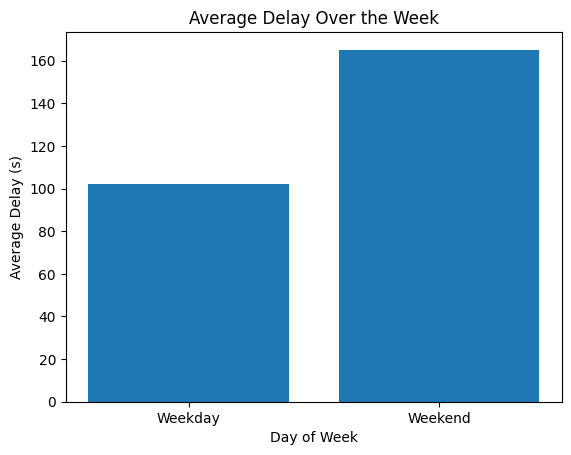

In [9]:
# Plots
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Average delay over the week

# Weekday dataset
df_weekday = df.loc[df['factor(day_of_week)weekday'] == 1]

# Weekend dataset
df_weekend = df.loc[df['factor(day_of_week)weekend'] == 1]

# Bar plot
fig, ax = plt.subplots()

x_axis = ["Weekday", "Weekend"]
y_axis = [
    df_weekday['arrival_delay'].mean(),
    df_weekend['arrival_delay'].mean()
]

ax.bar(x_axis, height = y_axis)

ax.set_ylabel('Average Delay (s)')
ax.set_xlabel('Day of Week')
ax.set_title('Average Delay Over the Week')

plt.show()

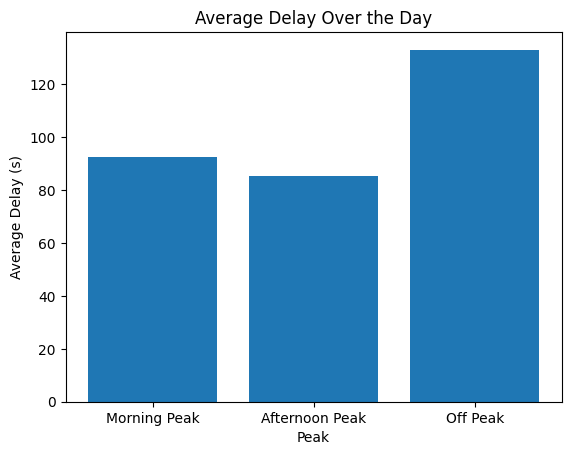

In [10]:
# Average delay over the day

# Morning peak dataset
df_morning_peak = df.loc[df['factor(time_of_day)Morning_peak'] == 1]

# Afternoon peak dataset
df_afternoon_peak = df.loc[df['factor(time_of_day)Afternoon_peak'] == 1]

# Off peak dataset
df_off_peak = df.loc[df['factor(time_of_day)Off-peak'] == 1]


# Bar plot
fig, ax = plt.subplots()

x_axis = ["Morning Peak", "Afternoon Peak", "Off Peak"]
y_axis = [
    df_morning_peak['arrival_delay'].mean(),
    df_afternoon_peak['arrival_delay'].mean(),
    df_off_peak['arrival_delay'].mean()
]

ax.bar(x_axis, height = y_axis)

ax.set_ylabel('Average Delay (s)')
ax.set_xlabel('Peak')
ax.set_title('Average Delay Over the Day')

plt.show()

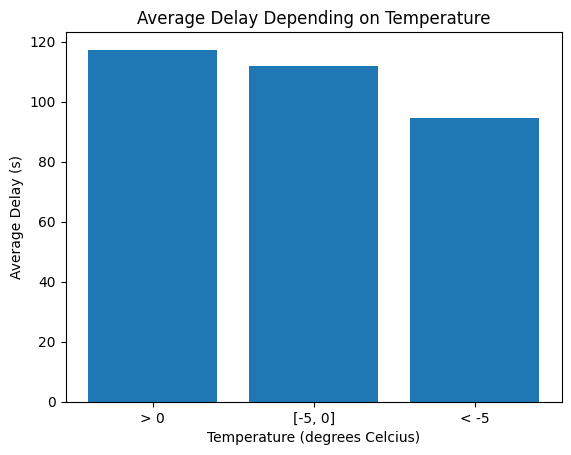

In [11]:
# Average delay depending on temperature

# Normal temperature dataset
df_normal_temp = df.loc[df['factor(temperature)Normal'] == 1]

# Cold temperature dataset
df_cold = df.loc[df['factor(temperature)Cold'] == 1]

# Extra cold temperature dataset
df_extra_cold = df.loc[df['factor(temperature)Extra_cold'] == 1]


# Bar plot
fig, ax = plt.subplots()

x_axis = ["> 0", "[-5, 0]", "< -5"]
y_axis = [
    df_normal_temp['arrival_delay'].mean(),
    df_cold['arrival_delay'].mean(),
    df_extra_cold['arrival_delay'].mean()
]

ax.bar(x_axis, height = y_axis)

ax.set_ylabel('Average Delay (s)')
ax.set_xlabel('Temperature (degrees Celcius)')
ax.set_title('Average Delay Depending on Temperature')

plt.show()

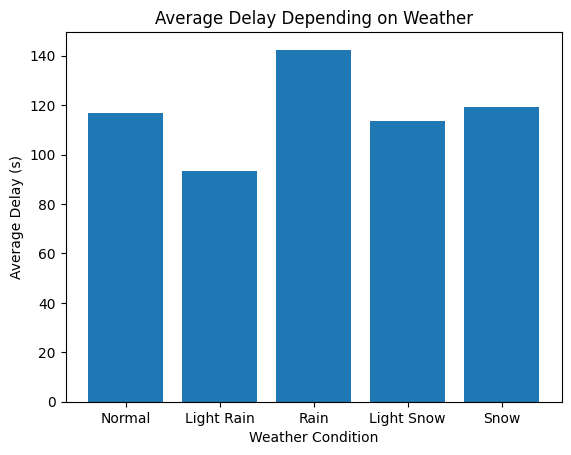

In [12]:
# Average delay depending on weather

# Normal weather dataset
df_normal_weather = df.loc[df['factor(weather)Normal'] == 1]

# Light rain dataset
df_light_rain = df.loc[df['factor(weather)Light_Rain'] == 1]

# Rain dataset
df_rain = df.loc[df['factor(weather)Rain'] == 1]

# Light snow dataset
df_light_snow = df.loc[df['factor(weather)Light_Snow'] == 1]

# Snow dataset
df_snow = df.loc[df['factor(weather)Snow'] == 1]

# Bar plot
fig, ax = plt.subplots()

x_axis = [
    "Normal",
    "Light Rain",
    "Rain",
    "Light Snow",
    "Snow"
]
y_axis = [
    df_normal_weather['arrival_delay'].mean(),
    df_light_rain['arrival_delay'].mean(),
    df_rain['arrival_delay'].mean(),
    df_light_snow['arrival_delay'].mean(),
    df_snow['arrival_delay'].mean()
]

ax.bar(x_axis, height = y_axis)

ax.set_ylabel('Average Delay (s)')
ax.set_xlabel('Weather Condition')
ax.set_title('Average Delay Depending on Weather')

plt.show()

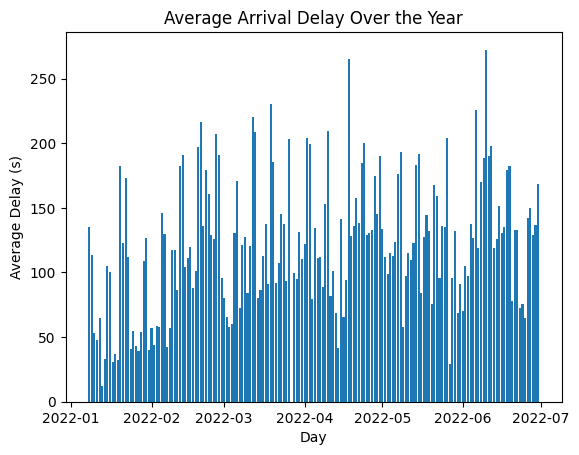

In [13]:
# Bar plot of daily averages with rain highlighted
fig, ax = plt.subplots()

x_axis = df_daily['Calendar_date']
y_axis = df_daily['avg_arrival_delay']

ax.bar(x_axis, height = y_axis)

ax.set_ylabel('Average Delay (s)')
ax.set_xlabel('Day')
ax.set_title('Average Arrival Delay Over the Year')

plt.show()

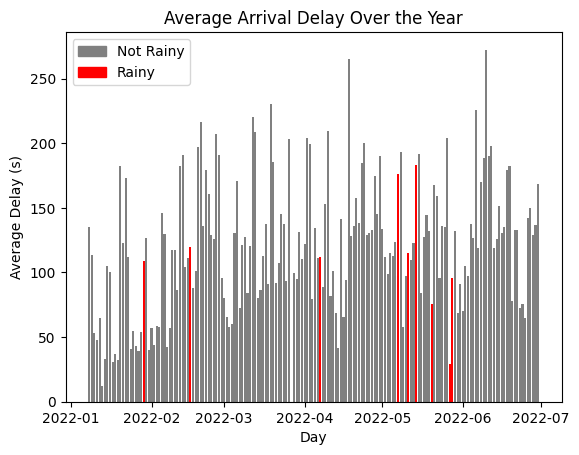

In [14]:
# Bar plot of daily averages with rain highlighted
fig, ax = plt.subplots()

x_axis = df_daily['Calendar_date']
y_axis = df_daily['avg_arrival_delay']

# Define a list of colors
clrs = []

for i, v in enumerate(x_axis):
  if x_axis[i] == df_daily['Calendar_date'][i] and df_daily['rain'][i] == 0:
    clrs.append('grey')
  else:
    clrs.append('red')

ax.bar(x_axis, height = y_axis, color = clrs)

ax.set_ylabel('Average Delay (s)')
ax.set_xlabel('Day')
ax.set_title('Average Arrival Delay Over the Year')
ax

plot_colors = {'Not Rainy': 'grey', 'Rainy': 'red'}
labels = list(plot_colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=plot_colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

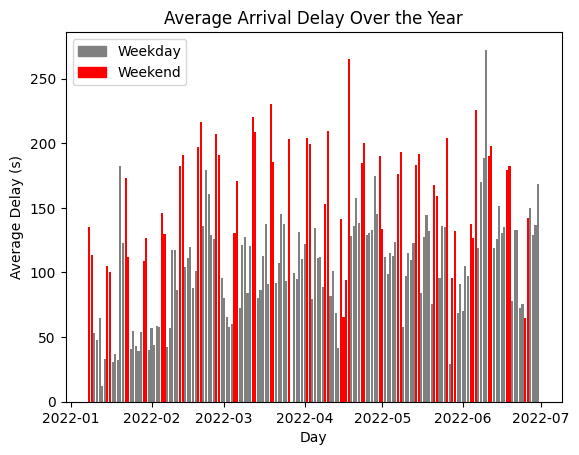

In [15]:
# Bar plot of daily averages with weekends highlighted
fig, ax = plt.subplots()

x_axis = df_daily['Calendar_date']
y_axis = df_daily['avg_arrival_delay']

# Define a list of colors
clrs = []

for i, v in enumerate(x_axis):

  if x_axis[i] == df_daily['Calendar_date'][i] and df_daily['weekend'][i] == 0:
    clrs.append('grey')
  else:
    clrs.append('red')

# Configuring bar plot
ax.bar(x_axis, height = y_axis, color = clrs)

ax.set_ylabel('Average Delay (s)')
ax.set_xlabel('Day')
ax.set_title('Average Arrival Delay Over the Year')
ax

plot_colors = {'Weekday': 'grey', 'Weekend': 'red'}
labels = list(plot_colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=plot_colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

## 1.3 Does Snow Affect Bus Cancellations?

In [16]:
# Is there a significant decrease in the number of buses running on days with snow?
snowy_days = 0
n_buses_snow = 0
n_buses_non_snow = 0

# Calculate the number of snowy days and the number of buses running on days with or without snow
for index, row in df_daily.iterrows():
  if row['snow'] > 0:
    snowy_days += 1
    n_buses_snow += row['n_buses']

  else:
    n_buses_non_snow += row['n_buses']

# Non snowy days
non_snowy_days = df_daily.shape[0] - snowy_days

# Averages
avg_buses_non_snow = n_buses_non_snow / non_snowy_days
avg_buses_snow = n_buses_snow / snowy_days

# Higher amount of buses on days with snow -> not a significant decrease
print('Average number of buses on days with snow:', avg_buses_snow)
print('Average number of buses on days without snow:', avg_buses_non_snow)

Average number of buses on days with snow: 134.11111111111111
Average number of buses on days without snow: 114.01829268292683


## 1.4 Dimensionality Reduction Using a Correlation Matrix

<ipython-input-17-cf1c4ba6c0b0>:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


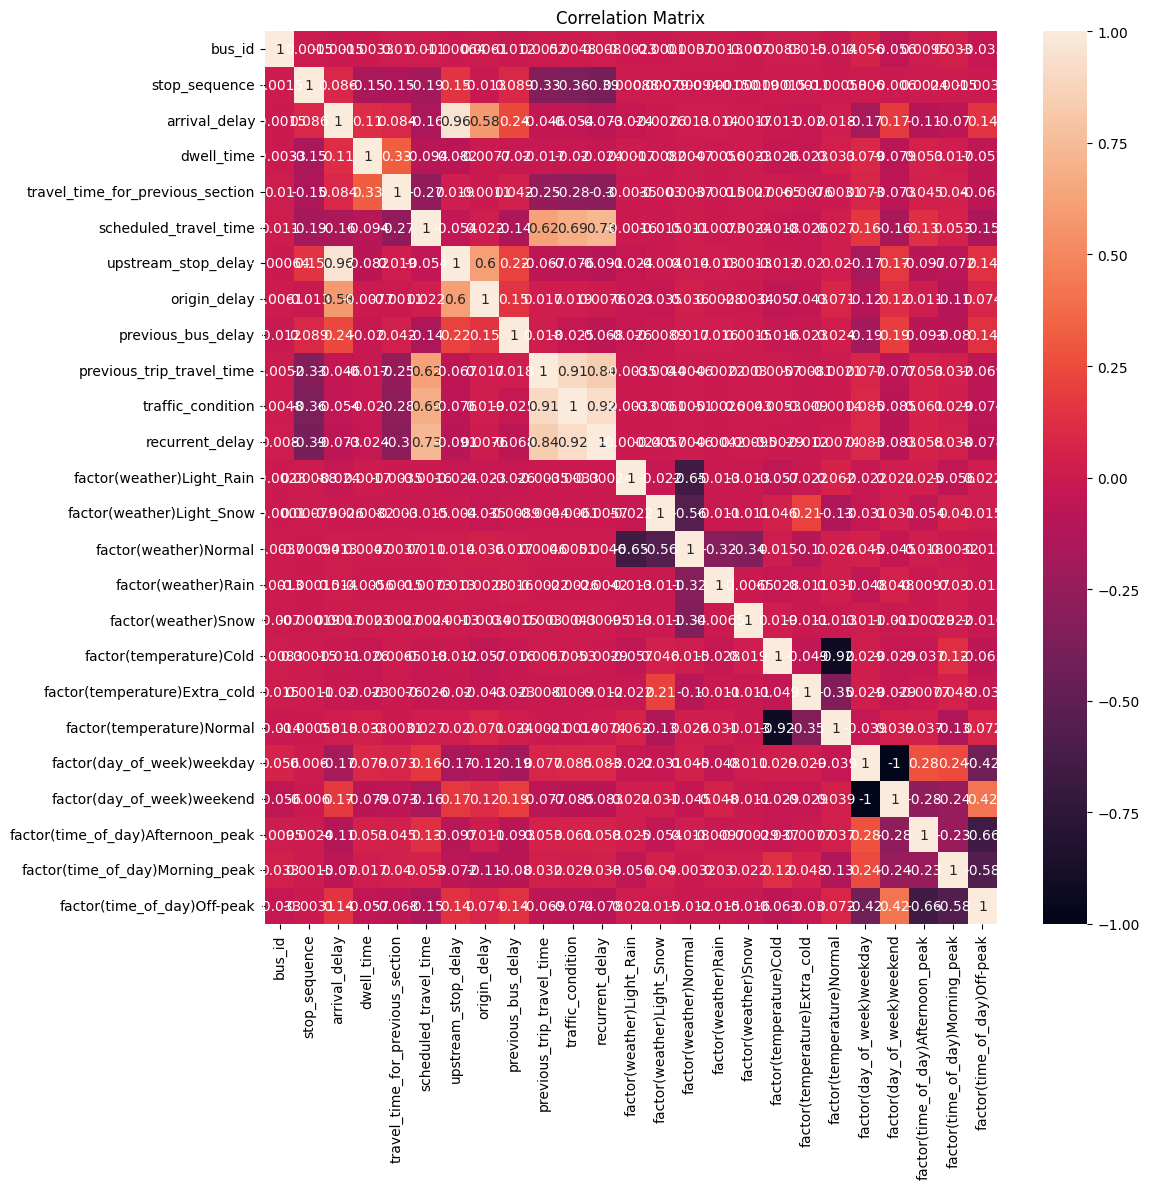

In [17]:
# Correlation Matrix
plt.subplots(figsize=(12,12))
corr = df.corr()
sns.heatmap(corr, annot = True)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [18]:
# Dropping the decided features from the DataFrame
df = df.drop([
    'traffic_condition',
    'recurrent_delay',
    'origin_delay',
    'factor(day_of_week)weekday',
    'factor(temperature)Cold',
    'factor(weather)Normal',
    'factor(time_of_day)Off-peak',
    'previous_trip_travel_time'
], axis = 1)

<ipython-input-19-a40295d63722>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


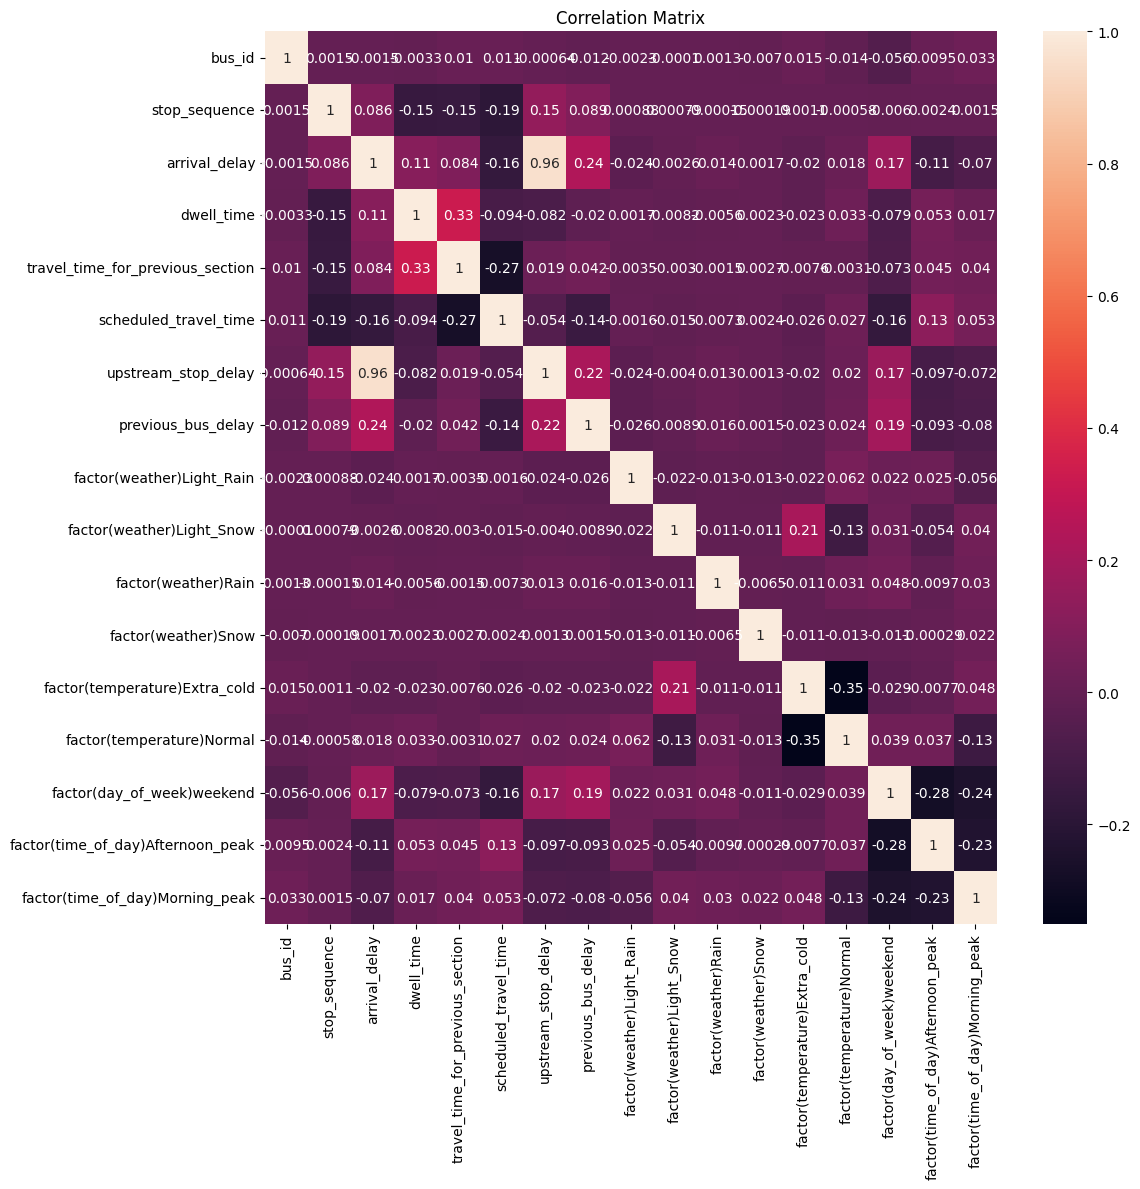

In [19]:
# Correlation Matrix
plt.subplots(figsize=(12,12))

corr = df.corr()
sns.heatmap(corr, annot = True)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 2. Model Selection

## 2.1 Generate a Subset of the Dataset for Model Selection Purposes

In [53]:
# Define a subset for training purposes, 1000 observations
import random

# Generate a list of 1000 random numbers in the range for a more representative subset of the data
rand_list = list()

while len(rand_list) < 1000:
  rand_int = random.randint(0, df.shape[0])
  if rand_int not in rand_list:
    rand_list.append(rand_int)

# Create the training dataset using the list of generated random numbers
df_subset = df.iloc[rand_list]
print('Number of observation in the subset:', df_subset.shape[0])

x = df_subset.drop(['arrival_delay', 'Calendar_date'], axis = 1) # , 'weather', 'temperature', 'day_of_week', 'time_of_day'
y = df_subset['arrival_delay']

Number of observation in the subset: 1000


## 2.2 Different Methods

### 2.2.1 Linear Regression

Cross Validation Score: 0.9696200730724429
Mean Absolute Error: 20.175214701164315
Mean Squared Error: 702.5657663135233
R-squared: 0.966624981149136


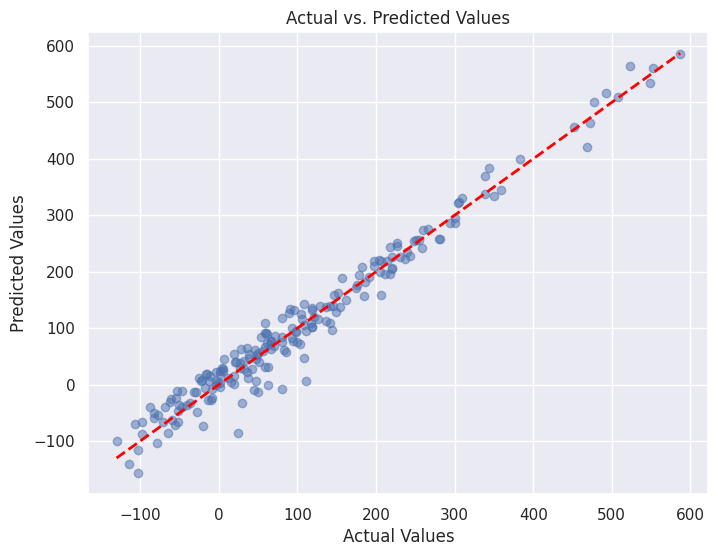

In [54]:
# Linear regression, for comparison
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create a Linear Regression model
model = LinearRegression()

print('Cross Validation Score:', cross_val_score(model, x, y, cv=5, error_score='raise').mean())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 2.2.2 SVM

In [23]:
# SVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define a parameter grid for hyperparameter tuning
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 40, 45],
    'epsilon': [0.01, 0.1, 1, 10, 20, 30, 40, 50]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVR(), param_grid, cv=5, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 552 candidates, totalling 2760 fits
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=10, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=10, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=10, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ....................C=10, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=10, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=10, epsilon=0

In [24]:
# Create an SVR model with the best parameters from the grid search
best_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], epsilon=best_params['epsilon'])

# Need to scale the input data as well
x_scaled = scaler.fit_transform(x)

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(best_svr, x_scaled , y, cv=5, verbose=2).mean()
print(cv_scores)

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
0.965922580032422


In [25]:
# Fit the model to the data
best_svr.fit(X_train_scaled, y_train)

SVR(C=13, epsilon=30, kernel='linear')

Mean Absolute Error: 19.71705788505735
Mean Squared Error: 709.7519381807232
R-squared: 0.9700778969107454


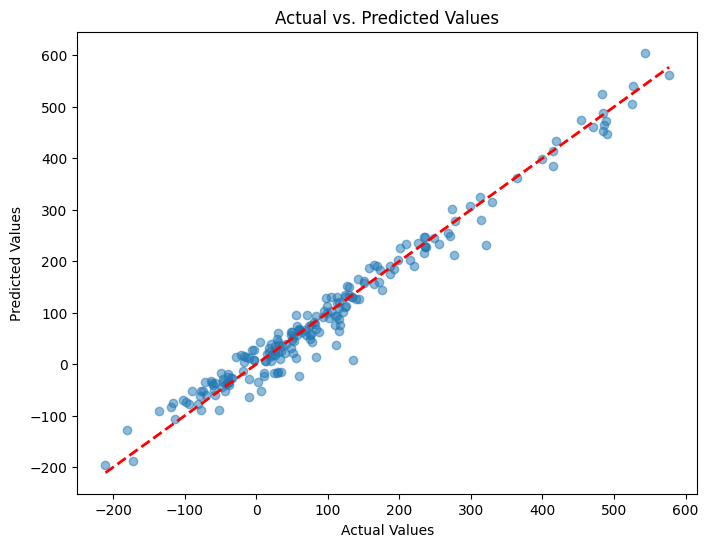

In [26]:
# Make predictions and evaluate
y_pred = best_svr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 2.2.3 XGBoost

In [27]:
# XGBoost
from xgboost import XGBRegressor

# Define a parameter grid for hyperparameter tuning
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 150, 175, 200, 225, 250, 300],
    'max_depth': [1, 2, 3, 4, 5, 6, 7]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(XGBRegressor(), params, cv=5, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=175; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=1, n

In [28]:
# Create an XGBoost model with the best parameters from the grid search
best_xg = XGBRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(best_xg, x , y, cv=5, verbose=2).mean()
print(cv_scores)

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
0.9698714526510933


In [29]:
# Fit the model to the data
best_xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Absolute Error: 17.099390577077866
Mean Squared Error: 518.0465382156907
R-squared: 0.9753904704618672


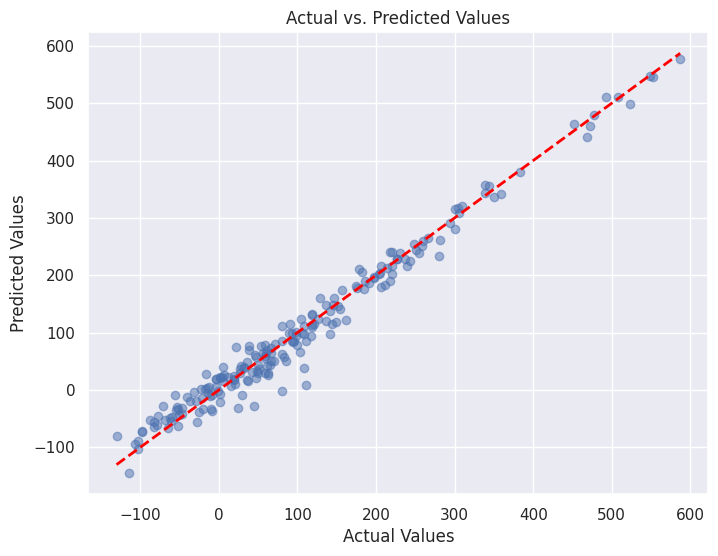

In [73]:
# Make predictions and evaluate
y_pred = best_xg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 2.2.4 RF

In [31]:
# RF
from sklearn.ensemble import RandomForestRegressor

params = {
     'n_estimators': [100, 200, 300],
     'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestRegressor(), params, cv=5, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END m

In [32]:
# Create an RF model with the best parameters from the grid search
best_rf = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(best_rf, x , y, cv=5, verbose=2).mean()
print(cv_scores)

[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.2s
0.9590353100298605


In [33]:
# Fit the model to the data
best_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=300)

Mean Absolute Error: 22.154194080919087
Mean Squared Error: 833.2780965557058
R-squared: 0.964870214837217


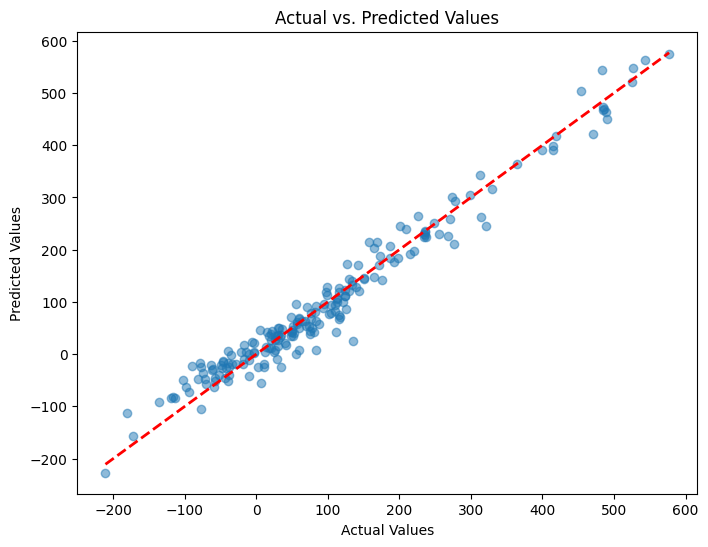

In [34]:
# Make predictions and evaluate
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 2.2.4 NN

In [81]:
# Determining the input dimension
input_dim = X_train.shape[1]
print("NN input dimension:", input_dim)

16


Epoch 1: val_mae improved from inf to 1406.94861, saving model to weights.best.h5

Epoch 2: val_mae improved from 1406.94861 to 274.67902, saving model to weights.best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mae improved from 274.67902 to 235.46411, saving model to weights.best.h5

Epoch 4: val_mae improved from 235.46411 to 109.35077, saving model to weights.best.h5

Epoch 5: val_mae improved from 109.35077 to 95.63406, saving model to weights.best.h5

Epoch 6: val_mae improved from 95.63406 to 86.78359, saving model to weights.best.h5

Epoch 7: val_mae improved from 86.78359 to 70.88130, saving model to weights.best.h5

Epoch 8: val_mae did not improve from 70.88130

Epoch 9: val_mae did not improve from 70.88130

Epoch 10: val_mae improved from 70.88130 to 58.88939, saving model to weights.best.h5

Epoch 11: val_mae did not improve from 58.88939

Epoch 12: val_mae improved from 58.88939 to 41.04197, saving model to weights.best.h5

Epoch 13: val_mae improved from 41.04197 to 33.77404, saving model to weights.best.h5

Epoch 14: val_mae did not improve from 33.77404

Epoch 15: val_mae did not improve from 33.77404

Epoch 16: val_mae did not improve from 33.77404

Epoch 17: v

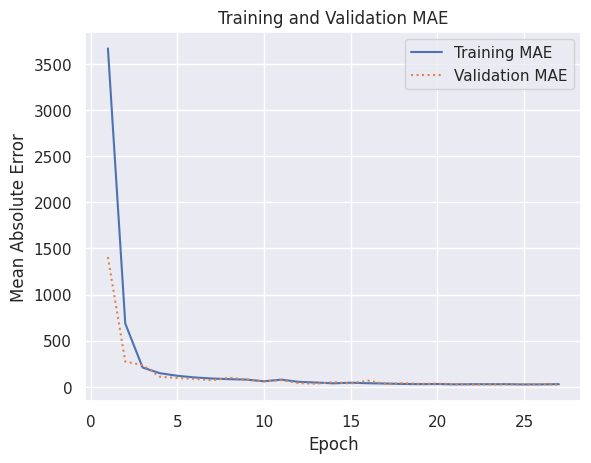

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LinearRegression
filepath=""

# Create a Sequential model, which is a linear stack of layers.
model = Sequential()

# Add a Dense layer with 32 units, ReLU activation, and an input dimension of 4.
model.add(Dense(128, activation='relu', input_dim=input_dim))


# Add another Dense layer with 64 units and ReLU activation.
#model.add(Dense(256, activation='relu'))

# Add a final Dense layer with 1 unit (typically used for regression tasks).
model.add(Dense(1))

# Compile the model with the Adam optimizer, Mean Absolute Error (MAE) loss function,
# and MAE metric to be used during training.
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# use the callback function to early stop, learning rate ajusting, save the best model
# Create an EarlyStopping callback to monitor the validation mean absolute error (val_mae).
# It will stop training if val_mae doesn't improve for 5 consecutive epochs and restores the best weights.
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Create a ReduceLROnPlateau callback to monitor val_mae.
# It reduces the learning rate by a factor of 0.5 if val_mae doesn't improve for 3 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

# Define the file path where the best model weights will be saved.
filepath = "weights.best.h5"

# Create a ModelCheckpoint callback to monitor the validation mae (val_mae).
# The callback will save the model's weights only if the validation mae improves.
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Train the model using the fit method.
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)


# Set the style of the plots using seaborn.
sns.set()

# Extract the training and validation Mean Absolute Error (MAE) from the training history.
err = hist.history['mae']
val_err = hist.history['val_mae']

# Define the number of epochs.
epochs = range(1, len(err) + 1)

# Plot the Training MAE and Validation MAE over epochs.
plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

# Use the trained model to predict on the test data.
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics.
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# 3. Model Creation and Evaluation

## 3.1 Linear Regression

### 3.1.1 Entire Dataset: Training and Evaluating the Model

Cross Validation Score: 0.9695838461044755
Mean Absolute Error: 19.05732298563634
Mean Squared Error: 669.7489005493935
R-squared: 0.9708964707753053


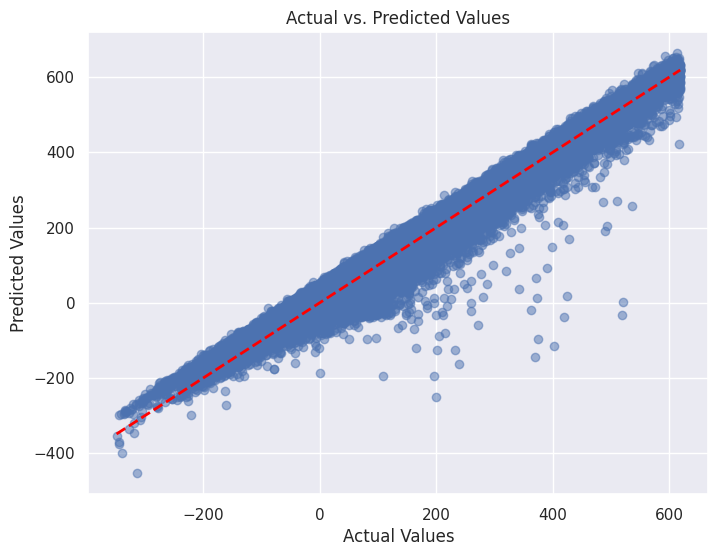

In [74]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


x = df.drop(['arrival_delay', 'Calendar_date'], axis = 1)
y = df['arrival_delay']

# Create a Linear Regression model
model = LinearRegression()

print('Cross Validation Score:', cross_val_score(model, x, y, cv=5, error_score='raise').mean())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 3.1.2 Evaluating the Model: Peak Hours

Mean Absolute Error: 20.613730571486933
Mean Squared Error: 784.5745373369031
R-squared: 0.9626501468488051


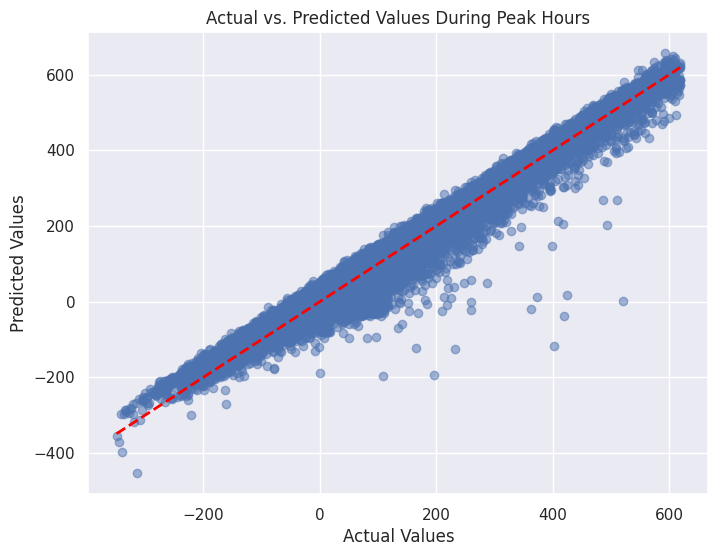

In [40]:
# Defining the peak hour subset
X_test_peak = X_test.loc[(df['factor(time_of_day)Afternoon_peak'] == 1) | (df['factor(time_of_day)Morning_peak'] == 1)]
y_pred_peak = model.predict(X_test_peak)

y_test_peak = y_test.loc[(df['factor(time_of_day)Afternoon_peak'] == 1) | (df['factor(time_of_day)Morning_peak'] == 1)]

mae = mean_absolute_error(y_test_peak, y_pred_peak)
mse = mean_squared_error(y_test_peak, y_pred_peak)
r2 = r2_score(y_test_peak, y_pred_peak)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_peak, y_pred_peak, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values During Peak Hours")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_peak), max(y_test_peak)], [min(y_test_peak), max(y_test_peak)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()


### 3.1.3 Evaluating the Model: Weekends

Mean Absolute Error: 17.45117833449728
Mean Squared Error: 551.3458158787959
R-squared: 0.9790745452039312


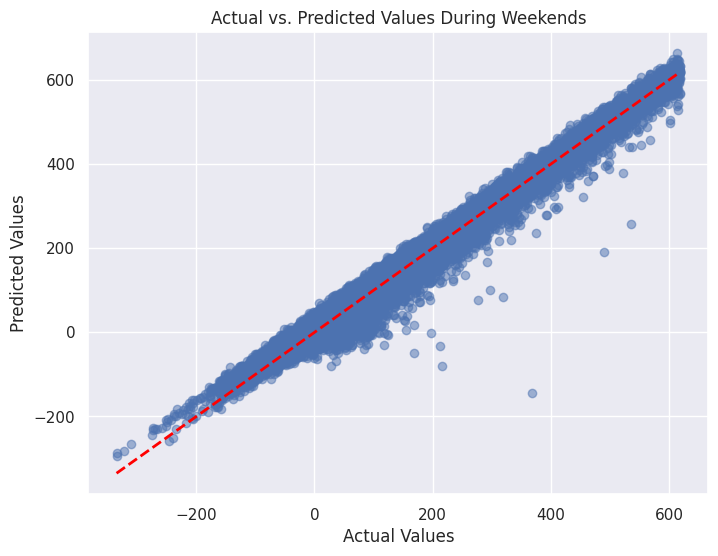

In [41]:
# Defining the weekend subset
X_test_weekend = X_test.loc[df['factor(day_of_week)weekend'] == 1]
y_pred_weekend = model.predict(X_test_weekend)

y_test_weekend = y_test.loc[df['factor(day_of_week)weekend'] == 1]

mae = mean_absolute_error(y_test_weekend, y_pred_weekend)
mse = mean_squared_error(y_test_weekend, y_pred_weekend)
r2 = r2_score(y_test_weekend, y_pred_weekend)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_weekend, y_pred_weekend, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values During Weekends")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_weekend), max(y_test_weekend)], [min(y_test_weekend), max(y_test_weekend)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

## 3.2 SVM

### 3.2.1 Entire Dataset: Training and Evaluating the Model

In [42]:
# It is too slow to train the model on all observations, only 5% is thus used
import random

rand_list = list()
n = int(df.shape[0]/20)

while len(rand_list) < n:
  rand_int = random.randint(0, df.shape[0])
  if rand_int not in rand_list:
    rand_list.append(rand_int)

# Create the training dataset using the list of generated random numbers
df_subset = df.iloc[rand_list]
print('Number of observation in the subset:', df_subset.shape[0])

x = df_subset.drop(['arrival_delay', 'Calendar_date'], axis = 1) #
y = df_subset['arrival_delay']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Number of observation in the subset: 26454


In [43]:
# SVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define a parameter grid for hyperparameter tuning
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [10, 20, 30], #[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 40, 45],
    'epsilon': [0.1, 1, 10] #[0.01, 0.1, 1, 10, 20, 30, 40, 50]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVR(), param_grid, cv=5, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...................C=10, epsilon=0.1, kernel=linear; total time=  28.9s
[CV] END ...................C=10, epsilon=0.1, kernel=linear; total time=  23.9s
[CV] END ...................C=10, epsilon=0.1, kernel=linear; total time=  22.1s
[CV] END ...................C=10, epsilon=0.1, kernel=linear; total time=  22.7s
[CV] END ...................C=10, epsilon=0.1, kernel=linear; total time=  22.8s
[CV] END .....................C=10, epsilon=0.1, kernel=poly; total time=  23.3s
[CV] END .....................C=10, epsilon=0.1, kernel=poly; total time=  25.4s
[CV] END .....................C=10, epsilon=0.1, kernel=poly; total time=  18.8s
[CV] END .....................C=10, epsilon=0.1, kernel=poly; total time=  20.5s
[CV] END .....................C=10, epsilon=0.1, kernel=poly; total time=  20.0s
[CV] END ......................C=10, epsilon=0.1, kernel=rbf; total time=  21.2s
[CV] END ......................C=10, epsilon=0.

In [44]:
# Create an SVR model with the best parameters from the grid search
best_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], epsilon=best_params['epsilon'])

# Need to scale the input data as well
x_scaled = scaler.fit_transform(x)

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(best_svr, x_scaled , y, cv=5, verbose=2).mean()
print(cv_scores)

[CV] END .................................................... total time=  38.9s
[CV] END .................................................... total time=  35.7s
[CV] END .................................................... total time=  33.5s
[CV] END .................................................... total time=  36.2s
[CV] END .................................................... total time=  34.8s
0.9727539437597363


In [45]:
# Fit the model to the data
best_svr.fit(X_train_scaled, y_train)

SVR(C=20, epsilon=10, kernel='linear')

Mean Absolute Error: 18.822868097189065
Mean Squared Error: 683.3202334746816
R-squared: 0.9703067367957718


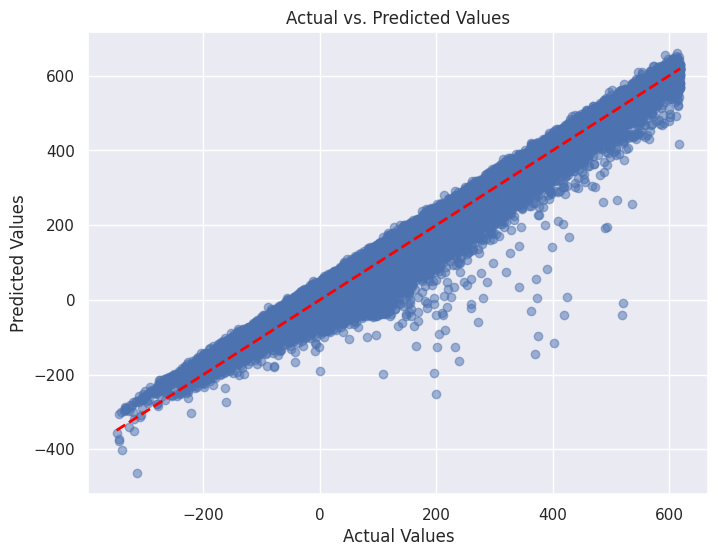

In [46]:
# Make predictions and evaluate
# Evaluate on entire dataset
x = df.drop(['arrival_delay', 'Calendar_date'], axis = 1)
y = df['arrival_delay']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate
y_pred = best_svr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 3.2.2 Evaluating the model: Peak Hours

Mean Absolute Error: 20.339258372699007
Mean Squared Error: 799.9586034995698
R-squared: 0.9619177848045382


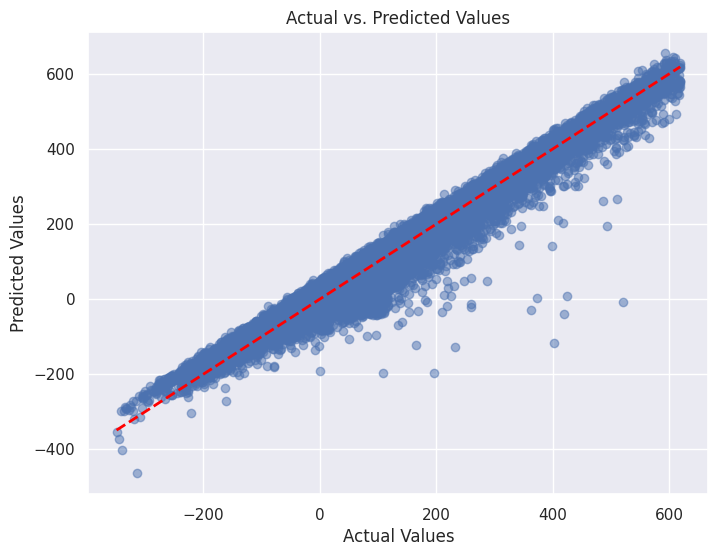

In [47]:
# Defining the peak hour subset
X_test_peak = X_test.loc[(df['factor(time_of_day)Afternoon_peak'] == 1) | (df['factor(time_of_day)Morning_peak'] == 1)]

X_test_scaled_peak = scaler.transform(X_test_peak)

y_pred_peak = best_svr.predict(X_test_scaled_peak)
mae = mean_absolute_error(y_test_peak, y_pred_peak)
mse = mean_squared_error(y_test_peak, y_pred_peak)
r2 = r2_score(y_test_peak, y_pred_peak)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_peak, y_pred_peak, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_peak), max(y_test_peak)], [min(y_test_peak), max(y_test_peak)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 3.2.3 Evaluating the Model: Weekends

Mean Absolute Error: 17.229332167630297
Mean Squared Error: 561.707170866899
R-squared: 0.9786812964312277


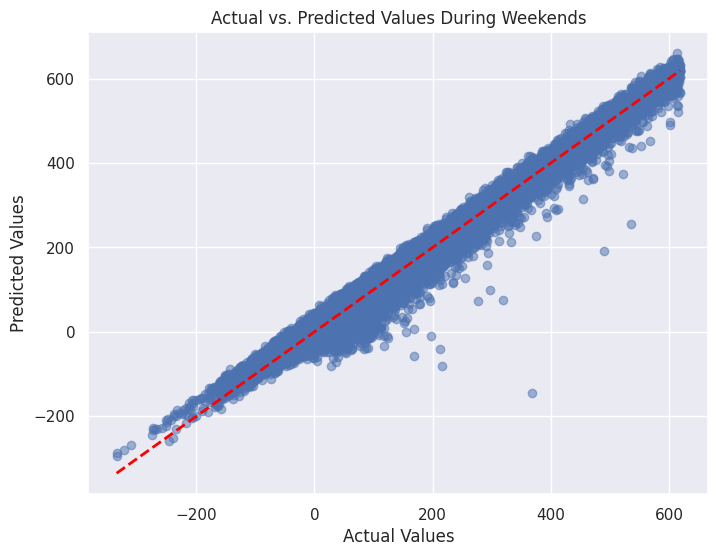

In [48]:
# Defining the weekend subset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_test_weekend = y_test.loc[df['factor(day_of_week)weekend'] == 1]

X_test_weekend = X_test.loc[df['factor(day_of_week)weekend'] == 1]

X_test_scaled_weekend = scaler.transform(X_test_weekend)

y_pred_weekend = best_svr.predict(X_test_scaled_weekend)


mae = mean_absolute_error(y_test_weekend, y_pred_weekend)
mse = mean_squared_error(y_test_weekend, y_pred_weekend)
r2 = r2_score(y_test_weekend, y_pred_weekend)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_weekend, y_pred_weekend, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values During Weekends")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_weekend), max(y_test_weekend)], [min(y_test_weekend), max(y_test_weekend)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

## 3.3 NN

### 3.3.1 Entire Dataset: Training and Evaluating the Model


Epoch 1: val_mae improved from inf to 25.35871, saving model to weights.best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae did not improve from 25.35871

Epoch 3: val_mae improved from 25.35871 to 21.03024, saving model to weights.best.h5

Epoch 4: val_mae did not improve from 21.03024

Epoch 5: val_mae did not improve from 21.03024

Epoch 6: val_mae improved from 21.03024 to 19.10273, saving model to weights.best.h5

Epoch 7: val_mae did not improve from 19.10273

Epoch 8: val_mae did not improve from 19.10273

Epoch 9: val_mae did not improve from 19.10273

Epoch 10: val_mae did not improve from 19.10273

Epoch 11: val_mae did not improve from 19.10273
3307/3307 [==============================] - 5s 1ms/step
Mean Absolute Error: 19.02511847021646
Mean Squared Error: 702.3876038947675
R-squared: 0.9694781758652442


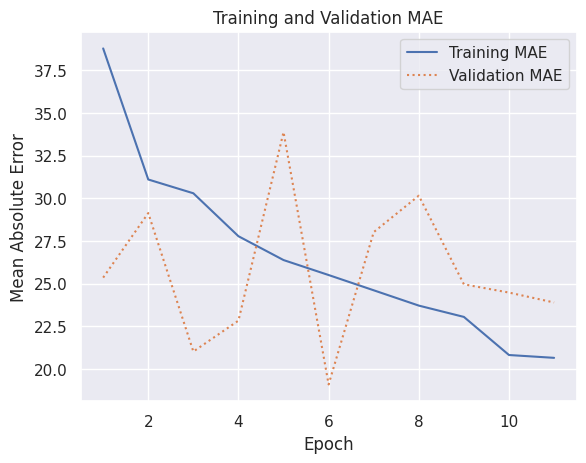

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LinearRegression
filepath=""

# Create a Sequential model, which is a linear stack of layers.
model = Sequential()

# Add a Dense layer with 32 units, ReLU activation, and an input dimension of 4.
model.add(Dense(128, activation='relu', input_dim=input_dim))

# Add another Dense layer with 64 units and ReLU activation.
#model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

# Add a final Dense layer with 1 unit (typically used for regression tasks).
model.add(Dense(1))

# Compile the model with the Adam optimizer, Mean Absolute Error (MAE) loss function,
# and MAE metric to be used during training.
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# use the callback function to early stop, learning rate ajusting, save the best model
# Create an EarlyStopping callback to monitor the validation mean absolute error (val_mae).
# It will stop training if val_mae doesn't improve for 5 consecutive epochs and restores the best weights.
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Create a ReduceLROnPlateau callback to monitor val_mae.
# It reduces the learning rate by a factor of 0.5 if val_mae doesn't improve for 3 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

# Define the file path where the best model weights will be saved.
filepath = "weights.best.h5"

# Create a ModelCheckpoint callback to monitor the validation mae (val_mae).
# The callback will save the model's weights only if the validation mae improves.
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Train the model using the fit method.
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

# Set the style of the plots using seaborn.
sns.set()

# Extract the training and validation Mean Absolute Error (MAE) from the training history.
err = hist.history['mae']
val_err = hist.history['val_mae']

# Define the number of epochs.
epochs = range(1, len(err) + 1)

# Plot the Training MAE and Validation MAE over epochs.
plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

# Use the trained model to predict on the test data.
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics.
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

### 3.3.2 Evaluating the Model: Peak Hours

In [50]:
# Defining the peak hour subset
X_test_peak = X_test.loc[(df['factor(time_of_day)Afternoon_peak'] == 1) | (df['factor(time_of_day)Morning_peak'] == 1)]

y_test_peak = y_test.loc[(df['factor(time_of_day)Afternoon_peak'] == 1) | (df['factor(time_of_day)Morning_peak'] == 1)]
# Use the trained model to predict on the test data.
y_pred_peak = model.predict(X_test_peak)

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
mae = mean_absolute_error(y_test_peak, y_pred_peak)
mse = mean_squared_error(y_test_peak, y_pred_peak)
r2 = r2_score(y_test_peak, y_pred_peak)

# Print the evaluation metrics.
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

1256/1256 [==============================] - 2s 1ms/step
Mean Absolute Error: 20.51682194152471
Mean Squared Error: 818.2928191618417
R-squared: 0.961044980207855


### 3.3.3 Evaluating the Model: Weekends

In [51]:
# Defining the weekend subset
y_test_weekend = y_test.loc[df['factor(day_of_week)weekend'] == 1]

X_test_weekend = X_test.loc[df['factor(day_of_week)weekend'] == 1]

# Use the trained model to predict on the test data.
y_pred_weekend = model.predict(X_test_weekend)

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
mae = mean_absolute_error(y_test_weekend, y_pred_weekend)
mse = mean_squared_error(y_test_weekend, y_pred_weekend)
r2 = r2_score(y_test_weekend, y_pred_weekend)

# Print the evaluation metrics.
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

743/743 [==============================] - 1s 1ms/step
Mean Absolute Error: 17.43362520501317
Mean Squared Error: 579.2502126252697
R-squared: 0.97801547814309


## 3.4 XGBoost

### 3.4.1 Entire Dataset: Training and Evaluating the Model

In [75]:
# XGBoost
from xgboost import XGBRegressor

# Define a parameter grid for hyperparameter tuning
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 150, 175, 200, 225, 250, 300],
    'max_depth': [1, 2, 3, 4, 5, 6, 7]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(XGBRegressor(), params, cv=5, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   3.4s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   1.4s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   3.4s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   2.5s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=150; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=175; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=1, n

In [76]:
# Create an XGBoost model with the best parameters from the grid search
best_xg = XGBRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(best_xg, x , y, cv=5, verbose=2).mean()
print(cv_scores)

[CV] END .................................................... total time=  14.8s
[CV] END .................................................... total time=  13.2s
[CV] END .................................................... total time=  14.5s
[CV] END .................................................... total time=  13.6s
[CV] END .................................................... total time=  14.1s
0.9828602743517377


In [77]:
# Fit the model to the data
best_xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Absolute Error: 12.532158890035577
Mean Squared Error: 375.3007494340026
R-squared: 0.9836915352600915


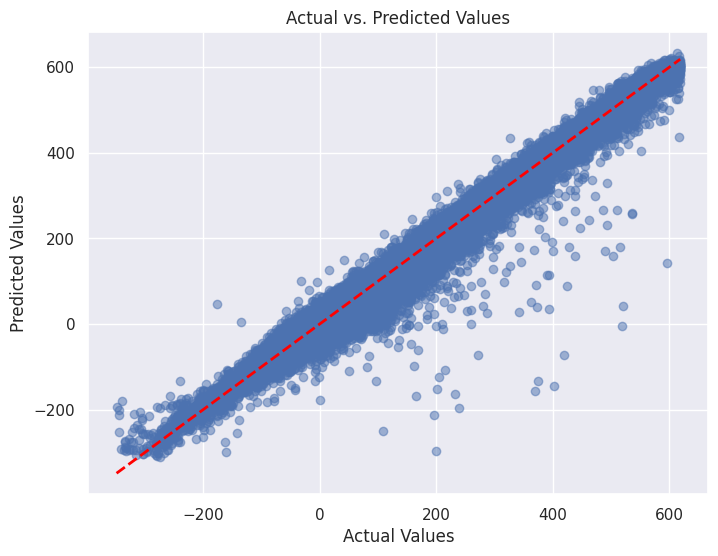

In [78]:
# Make predictions and evaluate
y_pred = best_xg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 3.4.2 Evaluating the Model: Peak Hours

Mean Absolute Error: 13.699643501606488
Mean Squared Error: 442.88858360937
R-squared: 0.9789161860690777


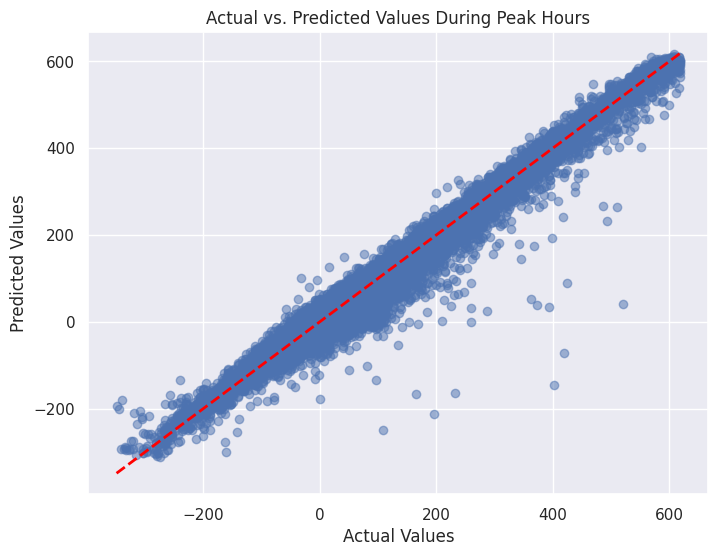

In [79]:
# Defining the peak hour subset
X_test_peak = X_test.loc[(df['factor(time_of_day)Afternoon_peak'] == 1) | (df['factor(time_of_day)Morning_peak'] == 1)]
y_pred_peak = best_xg.predict(X_test_peak)

y_test_peak = y_test.loc[(df['factor(time_of_day)Afternoon_peak'] == 1) | (df['factor(time_of_day)Morning_peak'] == 1)]

mae = mean_absolute_error(y_test_peak, y_pred_peak)
mse = mean_squared_error(y_test_peak, y_pred_peak)
r2 = r2_score(y_test_peak, y_pred_peak)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_peak, y_pred_peak, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values During Peak Hours")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_peak), max(y_test_peak)], [min(y_test_peak), max(y_test_peak)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

### 3.4.3 Evaluating the Model: Weekends

Mean Absolute Error: 11.071134427194119
Mean Squared Error: 296.08204783807815
R-squared: 0.98876267611084


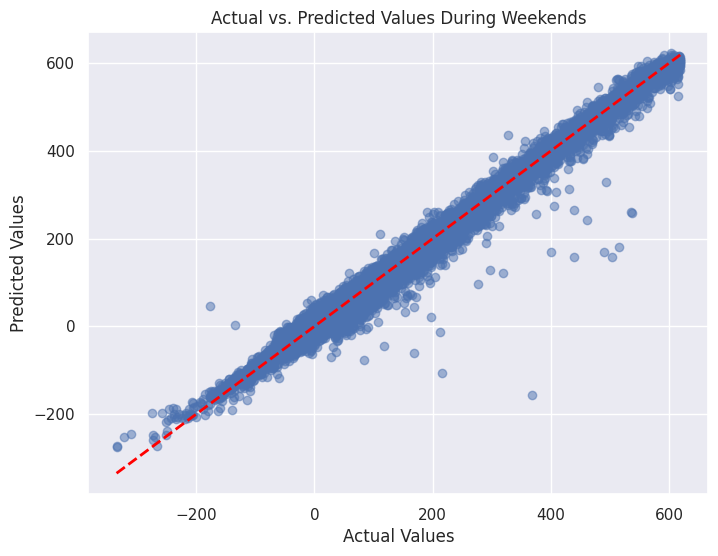

In [80]:
# Defining the weekend subset
X_test_weekend = X_test.loc[df['factor(day_of_week)weekend'] == 1]
y_pred_weekend = best_xg.predict(X_test_weekend)

y_test_weekend = y_test.loc[df['factor(day_of_week)weekend'] == 1]

mae = mean_absolute_error(y_test_weekend, y_pred_weekend)
mse = mean_squared_error(y_test_weekend, y_pred_weekend)
r2 = r2_score(y_test_weekend, y_pred_weekend)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_weekend, y_pred_weekend, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values During Weekends")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_weekend), max(y_test_weekend)], [min(y_test_weekend), max(y_test_weekend)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()